# Generation of artifical sequence data based on Categorical Mixture Models

This notebook is an example of how to generate artifical sequences for the HLA-A gene using our approach based on categorical mixture models.

## Section 1: Setup

In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
from gentype import AlleleMM, write_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

Set up Classes:

In [2]:
Database_Name = "Gentype_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Setting the paramaters for our selected allele: HLA-A. For options for ref_name and population_name you can also take a look at the database after fetching.

In [3]:
region_start = 29941260
region_end = 29945884
ref_name = "6" # generally the name of the chromosome
population_name = "ALL"
project_name = "1000GENOMES:phase_3"
allele_args = {'start' : region_start, 'end' : region_end, 'reference_name' : ref_name, 'population' : population_name, 'project' : project_name}

We use store magic to store the values of costly computations (data fetching, model training), so they only have to be done once.

Initialize storable data:

In [4]:
fetched = False
inference_matrix = None
models = None

Restore stored data (remove # to recompute instead of restore respective data):

In [5]:
#%store -d fetched # if you want to refetch the data, uncomment this line
#%store -d inference_matrix # if you want to recompute the inference_matrix, uncomment this line
#%store -d models # if you want to recompute the models, uncomment this line
%store -r

## Section 2: Collecting and preparing data

Fetches all HLA-A data obtained in 1000 Genomes project phase3 and stores them in a local sqlite server. This only needs to be done once but might take a while.

In [6]:
if not fetched:
    data_manager.fetch_all(region_start, region_end, ref_name, report_progress = True)
fetched = True
%store fetched

Stored 'fetched' (bool)


The following generates an inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. 

Each row in the matrix represents the variants present in each individual as a bitvector.

In [7]:
if inference_matrix is None:
    inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(**allele_args)
%store inference_matrix 
%store individual_map 
%store variation_map
inference_matrix.shape

Stored 'inference_matrix' (ndarray)
Stored 'individual_map' (dict)
Stored 'variation_map' (dict)


(5008, 438)

Mean number of variations per allele, for HLA-A as expected high.

In [8]:
inference_matrix.sum(axis=1).mean()

91.09704472843451

## Section 3: Training the Model

Train models with different initializations without seeding.

Here we compute different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore inference with high alphas tends to begin with a higher number of clusters. This might take a while.

Model 0:


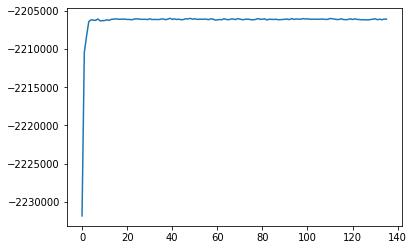

Model 1:


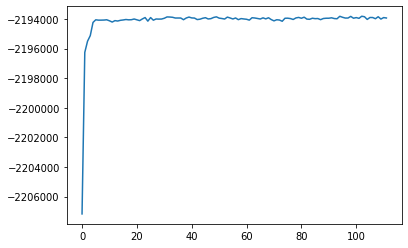

Model 2:


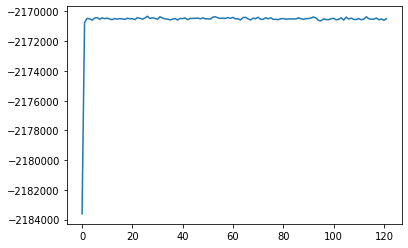

Stored 'models' (list)


In [9]:
number_models = 3
if models is None:
    models = [PiCollapsedNonparametricGibbsSampler(42) for i in range(number_models)]
    for i in range(0, len(models)):
        print("Model {}:".format(i))
        models[i].fit(inference_matrix, num_burn_in_steps = 100, delta = 1, alpha = 10**(i - 1))
for i in range(0, len(models)):
    print("Model {}:".format(i))
    plt.clf()
    plt.plot(models[i].ll_list)
    plt.show()

%store models

May pre select models e.g. according to Aitikens Information Criterion (AIC).

In [10]:
def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood
values = list(map(lambda x: AIC(x), models))
print(values)
best_idx = values.index(min(values))
print("Chose model {}.".format(best_idx))

[4418365.997452459, 4396630.52404454, 4350605.522921976]
Chose model 2.


## Section 4: Model analysis

In this section we explore our model a little bit.

In [11]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()

array([0.34239843, 0.53971578])

=> Over 50% of the variation can be explained by the first two principle components.

In [12]:
inds = [0]*len(inference_matrix)
for ind, pos in individual_map.items():
    inds[2*pos] = ind
    inds[2*pos+1] = ind

populations = ["AFR", "AMR", "EAS", "EUR", "SAS"]
sub_populations = ['STU', 'CLM', 'BEB', 'CHS', 'LWK', 'ACB', 'FIN', 'KHV', 'TSI', 'PUR', 'GWD', 'CDX', 'GBR', 'ESN', 'MXL', 'IBS', 'CHB', 'JPT', 'CEU', 'PEL', 'ITU', 'ASW', 'MSL', 'YRI', 'GIH', 'PJL']
ind_map = data_manager.generate_individual_population_map()
population_index = []
sub_population_index = []
for ind in inds:
    for pop in ind_map[ind]:
        if pop in populations:
            population_index.append(populations.index(pop))
        if pop in sub_populations:
            sub_population_index.append(sub_populations.index(pop))
pops = np.array(population_index)
sub_pops = np.array(sub_population_index)

When we plot the individuals in the dimensions of the first two principle components we see that the variations seem to be spread through the populations. However, this might also be due to the strong dimensional reduction.

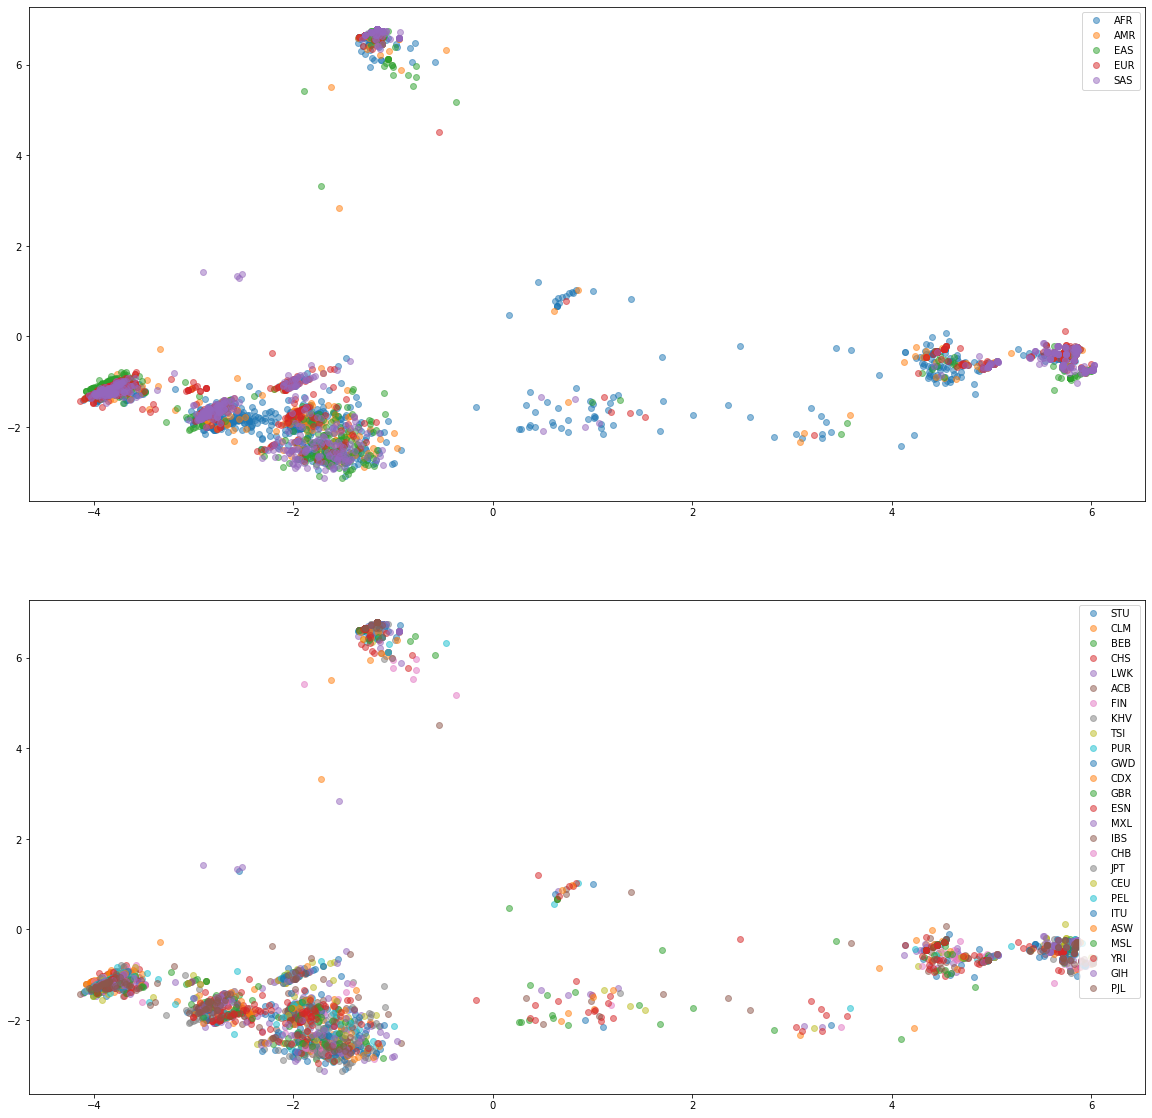

In [13]:
fig, ax = plt.subplots(nrows = 2, figsize = (20,20))

for i in range(len(pops)):
    ax[0].plot(principalComponents[pops == i,0], principalComponents[pops == i,1], "o", alpha=0.5)
ax[0].legend(populations)
for i in range(len(sub_pops)):
    ax[1].plot(principalComponents[sub_pops == i,0], principalComponents[sub_pops == i,1], "o", alpha=0.5)
ax[1].legend(sub_populations, loc = "upper right")

Plotting the same, but coloring the clusters determined by the mixture model gives some insight of how this model works. Still, we have to remember that this is a very strong dimensional reduction.

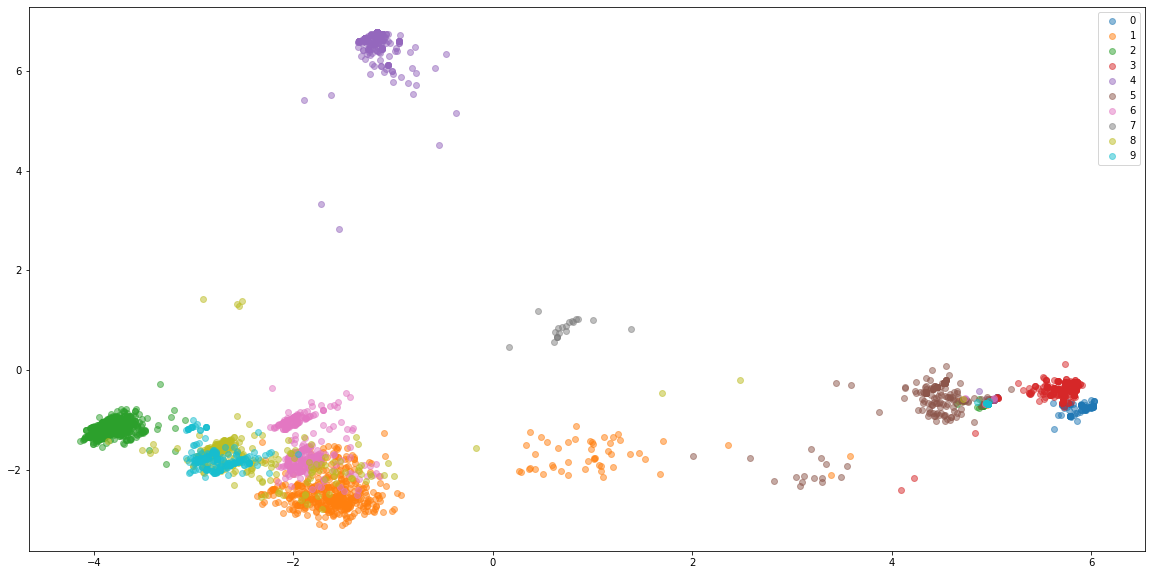

In [14]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(int(max(models[best_idx].Z))):
    ax.plot(principalComponents[models[best_idx].Z == i,0], principalComponents[models[best_idx].Z == i,1], "o", alpha=0.5)
ax.legend(range(int(max(models[best_idx].Z))))

We can also look at the distribution of populations and subpopulations within the clusters:

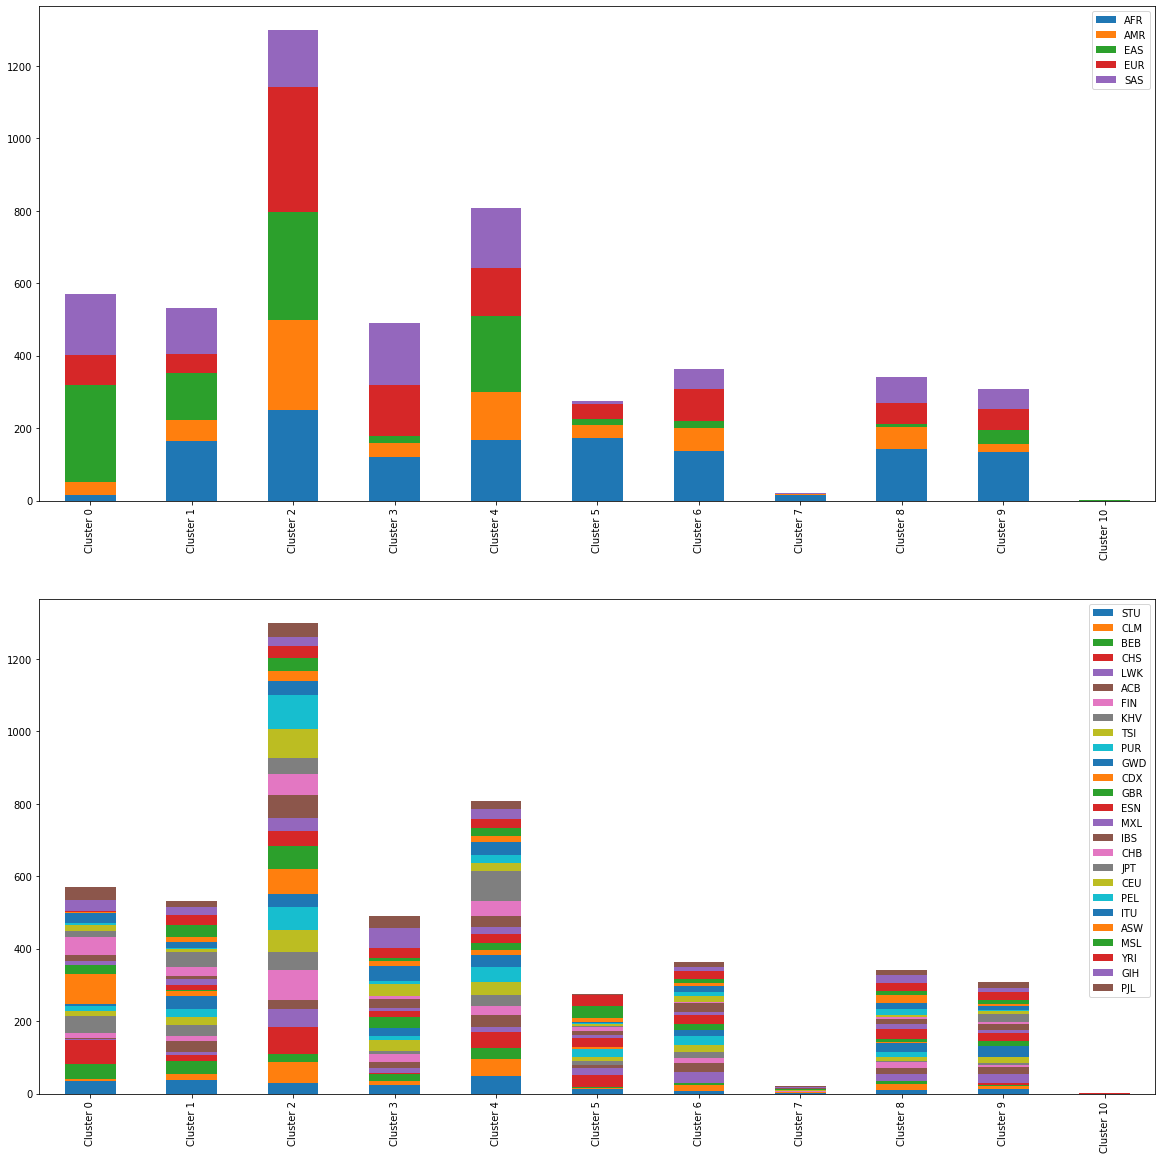

In [15]:
fig, ax = plt.subplots(nrows = 2, figsize=(20,20))
pops_per_cluster = np.array([np.histogram(pops[models[best_idx].Z == i], bins=len(populations))[0] for i in range(models[best_idx].K_seen)])
df = pd.DataFrame(dict(zip(populations, pops_per_cluster.T)))
df.index = ["Cluster " + str(i) for i in range(len(models[best_idx].theta))]
df.plot(kind="bar", stacked=True, ax=ax[0])
pops_per_cluster = np.array([np.histogram(sub_pops[models[best_idx].Z == i], bins=len(sub_populations))[0] for i in range(models[best_idx].K_seen)])
df = pd.DataFrame(dict(zip(sub_populations, pops_per_cluster.T)))
df.index = ["Cluster " + str(i) for i in range(len(models[best_idx].theta))]
df.plot(kind="bar", stacked=True, ax=ax[1])

In [16]:
pops_per_cluster

array([[34,  7, 41, 67,  2,  3, 12, 49, 14, 14,  3, 84, 24,  2,  9, 17,
        51, 15, 18,  6, 26,  3,  1,  2, 31, 34],
       [38, 17, 36, 16,  9, 28, 14, 32, 20, 22, 37, 13,  3, 15, 15,  9,
        25, 42,  7,  5, 16, 14, 31, 30, 20, 18],
       [30, 56, 23, 74, 50, 26, 81, 52, 59, 63, 37, 70, 62, 42, 35, 65,
        56, 44, 80, 95, 40, 25, 36, 34, 25, 39],
       [24, 10, 19,  3, 14, 18, 21,  9, 30, 12, 22,  0, 30, 17,  7, 25,
         7,  1, 34,  8, 41, 13,  9, 28, 56, 33],
       [48, 46, 33, 43, 14, 34, 25, 30, 35, 41, 33, 15, 19, 24, 21, 29,
        41, 82, 23, 23, 36, 17, 20, 26, 26, 23],
       [13,  2,  2, 33, 20,  9,  1, 10, 11, 23,  0,  5,  0, 24,  8, 13,
        11,  2,  5,  4,  2, 11, 34, 28,  1,  2],
       [ 8, 16,  4,  1, 31, 24, 14, 17, 18, 25, 17,  0, 18, 23, 10, 24,
         3,  0, 15, 12, 16,  9, 12, 20, 13, 12],
       [ 1,  2,  1,  0,  1,  0,  2,  0,  2,  0,  0,  0,  3,  0,  0,  2,
         0,  0,  0,  0,  0,  0,  0,  2,  3,  3],
       [10, 15, 10,  0, 18, 17, 

In the following we plot the probability for each variant for each of the clusters. We can see that each cluster has a distinct pattern of variants.

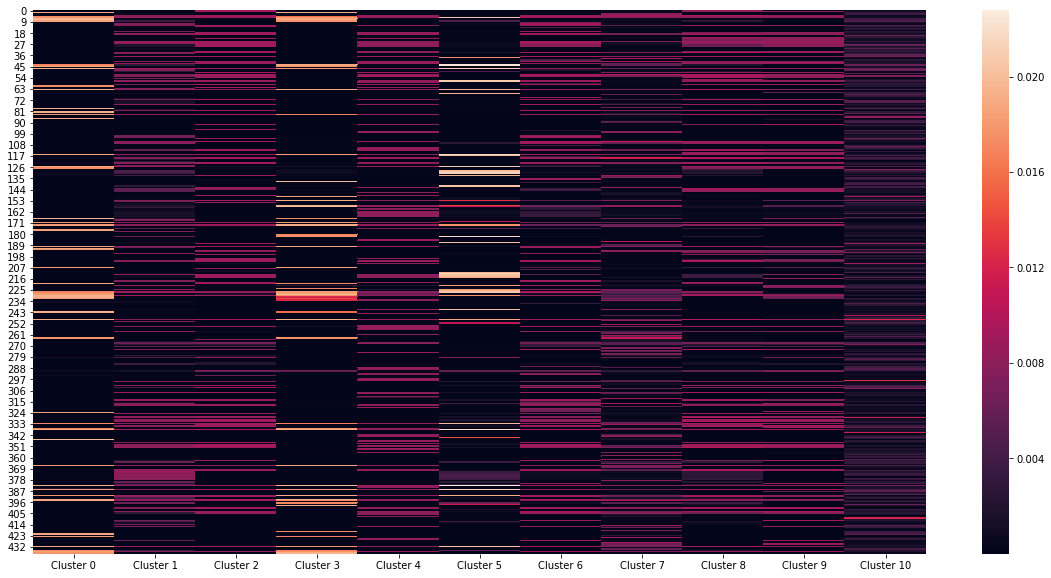

In [17]:
df = pd.DataFrame(dict(zip(["Cluster " + str(i) for i in range(len(models[best_idx].theta))], list(models[best_idx].theta))))
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)

## Section 5: Sequence Generation

The following builds a sequence generator from the parameters which were determined during model training.

In [18]:
variant_ranges = data_manager.get_variation_range(**allele_args)
mm = AlleleMM(models[best_idx].Z, models[best_idx].theta, inference_matrix, variant_ranges, variation_map)

We can then sample a set of indices which can be mapped to variant ids.

In [19]:
sample = mm.sample_variations()
len(sample)

55

We can compare the samples to the respective cluster. Here the choice of cluster is equally distributed. In the sampling without specified cluster it is determined based on infered paramters, i.e. in reality some clusters might be much more rare than it may seem here.

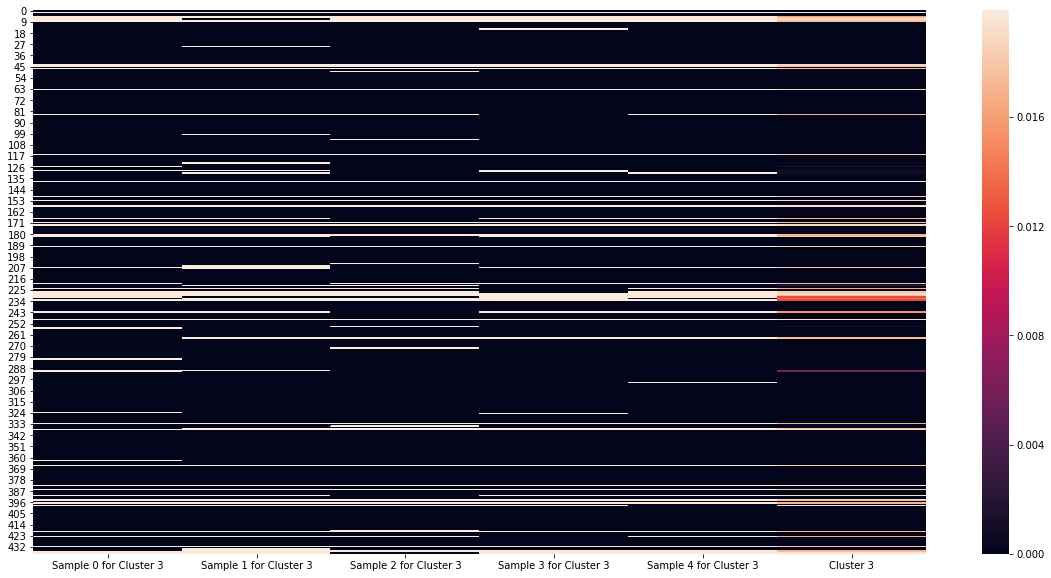

In [20]:
number_of_samples = 5
samples = []
descriptions = []
k = np.random.choice(range(int(max(models[best_idx].Z) + 1)))
theta = models[best_idx].theta[k]
indicator_value = theta.max()
for i in range(number_of_samples):
    characteristic_vector = np.zeros(len(theta))
    characteristic_vector[mm.sample_variations(k)] = indicator_value
    samples.append(characteristic_vector)
    descriptions.append("Sample {} for Cluster {}".format(i, k))
samples.append(theta)
descriptions.append("Cluster {}".format(k))
df = pd.DataFrame(dict(zip(descriptions, samples)))
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)
    

In order to now actually generate a sequence we first need to convert our bitvector back to variants.

In [21]:
invert_variation_map = {}
for key in variation_map:
    invert_variation_map[variation_map[key]] = key
alternates_map = data_manager.get_variation_alternate(**allele_args)

sample = mm.sample_variations()
selected_variants = [alternates_map[invert_variation_map[index]] for index in sample]
selected_variants.sort(key = lambda x: x[1])
#selected_variants

And then insert them into the reference sequence.

In [22]:
seq_data = data_manager.fetch_region(region_start, region_end, ref_name)
seq = seq_data['seq']
header = seq_data['id']
offset = region_start # to compute variant coordinates relative to region start
sequence_parts = []
start = 0
offset_start = 0
for variant in selected_variants:
    offset_start = variant[1] - offset
    offset_end = variant[2] - offset
    sequence_parts.append(seq[start: offset_start])
    sequence_parts.append(np.random.choice(variant[0]))
    start = offset_end
sequence_parts.append(seq[start:])
generated_sequence = "".join(sequence_parts)
#generated_sequence

We can also write the created sequences into a fasta file.

In [23]:
number_of_sequences = 5
sequences = []
headers = []
for i in range(number_of_sequences):
    sample = mm.sample_variations()
    selected_variants = [alternates_map[invert_variation_map[index]] for index in sample]
    selected_variants.sort(key = lambda x: x[1])
    sequence_parts = []
    start = 0
    offset_start = 0
    for variant in selected_variants:
        offset_start = variant[1] - offset
        offset_end = variant[2] - offset
        sequence_parts.append(seq[start: offset_start])
        sequence_parts.append(np.random.choice(variant[0]))
        start = offset_end
    sequence_parts.append(seq[start:])
    generated_sequence = "".join(sequence_parts)
    sequences.append(generated_sequence)
    headers.append(">{} - artifical variation {}".format(header, i))
write_sequences("Generated Variations.fasta", headers, sequences)

For comparison we also write the reference sequence to a seperate fasta file.

In [24]:
write_sequences("Reference Sequence.fasta", [">{}".format(header)], [seq])